### Load Dataset and perform Exploratory Data Analysis:  

In [1]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_deposit():
    # Load csv dataset
    term_deposit_filepath = '../data/raw/term-deposit-marketing-2020.csv'
    #customer_survey_filepath = 'ACME-HappinessSurvey2020.csv'
    term_deposit = pd.read_csv(term_deposit_filepath)
    return term_deposit
term_deposit = load_deposit()

### Exploratory Data Analysis:  


In [40]:
term_deposit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [4]:
term_deposit.describe().T

,count,mean,std,min,25%,50%,75%,max
age,40000.0,40.544600,9.641776,19.0,33.0,39.0,48.0,95.0
balance,40000.0,1274.277550,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
day,40000.0,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0
duration,40000.0,254.824300,259.366498,0.0,100.0,175.0,313.0,4918.0
campaign,40000.0,2.882175,3.239051,1.0,1.0,2.0,3.0,63.0


In [2]:
# Identify the categorical columns from the dataset.
categorical_cols = term_deposit.select_dtypes(include=['object']).columns
numerical_cols = term_deposit.select_dtypes(include=['int64']).columns

# Obtain unique values for each categorical column and count their occurrences for each column
category_summary = {col: term_deposit[col].value_counts().to_frame(name="count") for col in categorical_cols}
# Combine the summaries into a single dataframe for display
summary_combined = pd.concat(category_summary, axis=0)
summary_combined.index.names = ["feature", "category"]
print(summary_combined)

                         count
feature   category            
job       blue-collar     9383
          management      8166
          technician      6852
          admin           4483
          services        3910
          retired         1437
          self-employed   1414
          entrepreneur    1405
          unemployed      1104
          housemaid       1087
          student          524
          unknown          235
marital   married        24386
          single         10889
          divorced        4725
education secondary      20993
          tertiary       11206
          primary         6270
          unknown         1531
default   no             39191
          yes              809
housing   yes            24031
          no             15969
loan      no             33070
          yes             6930
contact   cellular       24914
          unknown        12765
          telephone       2321
month     may            13532
          jul             6380
        

#### Explore unknown values in dataset  

In [38]:
unknown_counts = (term_deposit == 'unknown').sum()
unknown_counts = unknown_counts[unknown_counts > 0]
unknown_counts

job            235
education     1531
contact      12765
dtype: int64

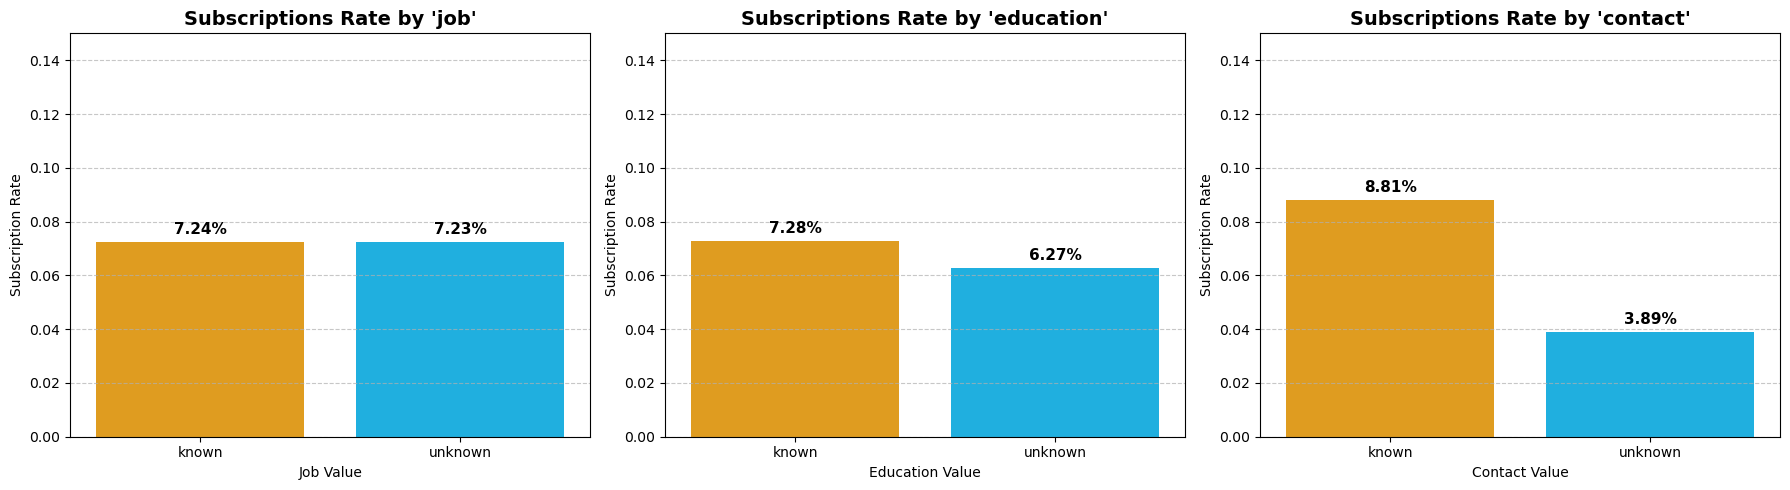

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_unknowns(term_deposit):
    unknown_deposit = term_deposit.copy()
    # Convert target to binary
    unknown_deposit["y"] = unknown_deposit["y"].map({"yes": 1, "no": 0})

    # features that contain unknown values
    unknown_features = ['job','education','contact']

    # loop creates new binary columns that indicate whether each row in a feature has unknown value
    """
    - Creates a new binary column for each feature (e.g., job_unknown)
    - True : if the row has value `unknown`
    - False : otherwise
    This allows comparsion between "known" vs "unknown" groups.
    """
    for feature in unknown_features:
        unknown_deposit[f"{feature}_unknown"] = unknown_deposit[feature] == 'unknown'

    # Create a 1x3 subplot grid
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

    # Plot success rates (proportion of y=1) for 'unknown' vs 'known' in each feature
    for i, feature in enumerate(unknown_features):
        col = f"{feature}_unknown"
        # compute the average of y (subscription) for each T/F group
        rate_term_deposit = unknown_deposit.groupby(col)["y"].mean().reset_index()
        # Relabel True and False
        rate_term_deposit[col] = rate_term_deposit[col].map({True: "unknown", False: "known"})

        ax = axes[i]
        ax = sns.barplot(data=rate_term_deposit, x=col, y="y", hue=col, palette=["orange", "deepskyblue"], legend=False, ax=ax)

         # Add percentage labels above bars
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 0.003,
                    f'{height * 100:.2f}%', ha="center", fontsize=11, fontweight='bold')
            
        ax.set_title(f"Subscriptions Rate by '{feature}'", fontsize=14, fontweight='bold')
        ax.set_ylabel('Subscription Rate')
        ax.set_xlabel(f'{feature.capitalize()} Value')
        ax.set_ylim(0,0.15)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_unknowns(term_deposit)

The percentage of unknown jobs for the category jobs is 0.6%. The total count of unknowns (235) is relatively small so I will keep these rows. From the subscription rate for known and unknown jobs, we see that people who do not disclose their jobs are slightly less likely to subscribe.  

Those with an unknown education have a lower subscription rate of 6.27% compared to known 7.28%. This significant lower subscription rate implies those with unknown education are less financially engaged or less responsive.  

Unknown contacts make up 32% which is a substantial amount of the contacts feature and would not be viable to be dropped from the dataset. Those with unknown contact means have a subscription rate of 3.89% compared to 8.81% This difference suggests that contact type is a meaningful signal. I will keep unknown as a valid level in one-hot encoding instead of imputing or removing this unknown values from the features.


#### Correlation heat map:  

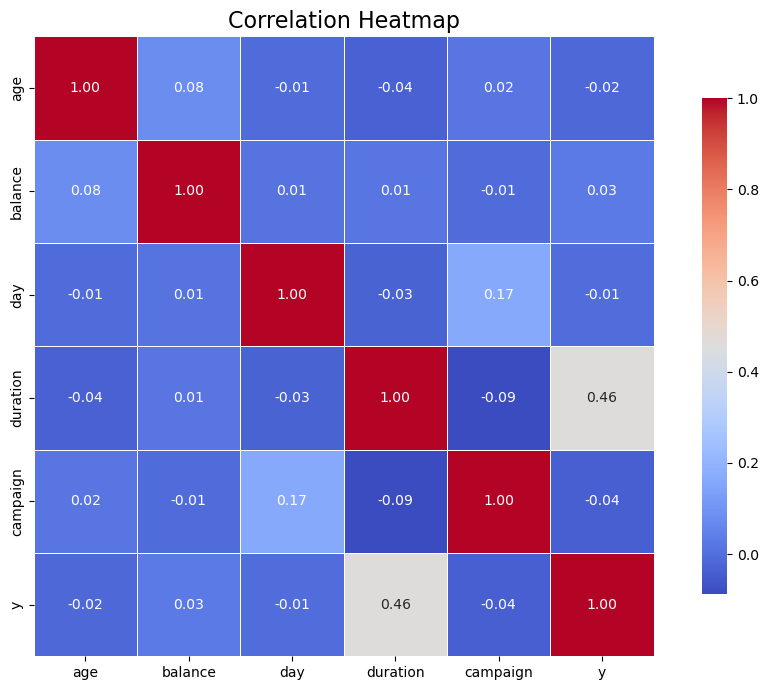

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# heatmap ofr 
def heatmap(term_deposit):
    correlation_deposit = term_deposit.copy()
    correlation_deposit['y'] = correlation_deposit['y'].map({'yes':1, 'no':0})
    correlation_matrix = correlation_deposit.corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(10,7))

    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        linewidth=0.5,
        square=True,
        cbar_kws={'shrink':0.8},
        ax=ax
        )
    # Set Title
    ax.set_title("Correlation Heatmap", fontsize=16)
    # Adjust layout to prevent clipping
    fig.tight_layout()
    # Show plot
    plt.show()
heatmap(term_deposit)

There is notable correlation between duration and target variable. Very little correlations between each othe features, implies they are independent. No major colinearity among the freatures. 

#### Feature Distributions Numerical
The following plots display the skewness value, histogram shape and Q-Q plot shape for each of the numerical features in the dataset. Q-Q plots, histograms, and skewness values are used to understand the shape and symmetry of the feature distributions in order to decide how I would preprocess features before modeling. The histogram plots will show the distribution of values for the numerical features to give a visual overview of how a feature is spread across its range. The skewness value measures the asymmetry of a distribution. A normal distribution has a skewness ~ 0, a positive skew (right-skewed) visually has a long tail on the right (high values), and a negative skew (left-skewed) visually has a long tail on the left (low values). Quantile-Quantile (QQ) plots were utilized as a graphical tool to compare the distribution of the feature dataset against the normal distribution. Ideally the points should fall roughly on a straight line for the data to approximately be normally distributed. Some models (Logistic Regression, SVM and KNN) assume features are normally distributed and strong skewness or outliers can break these model’s performance.   

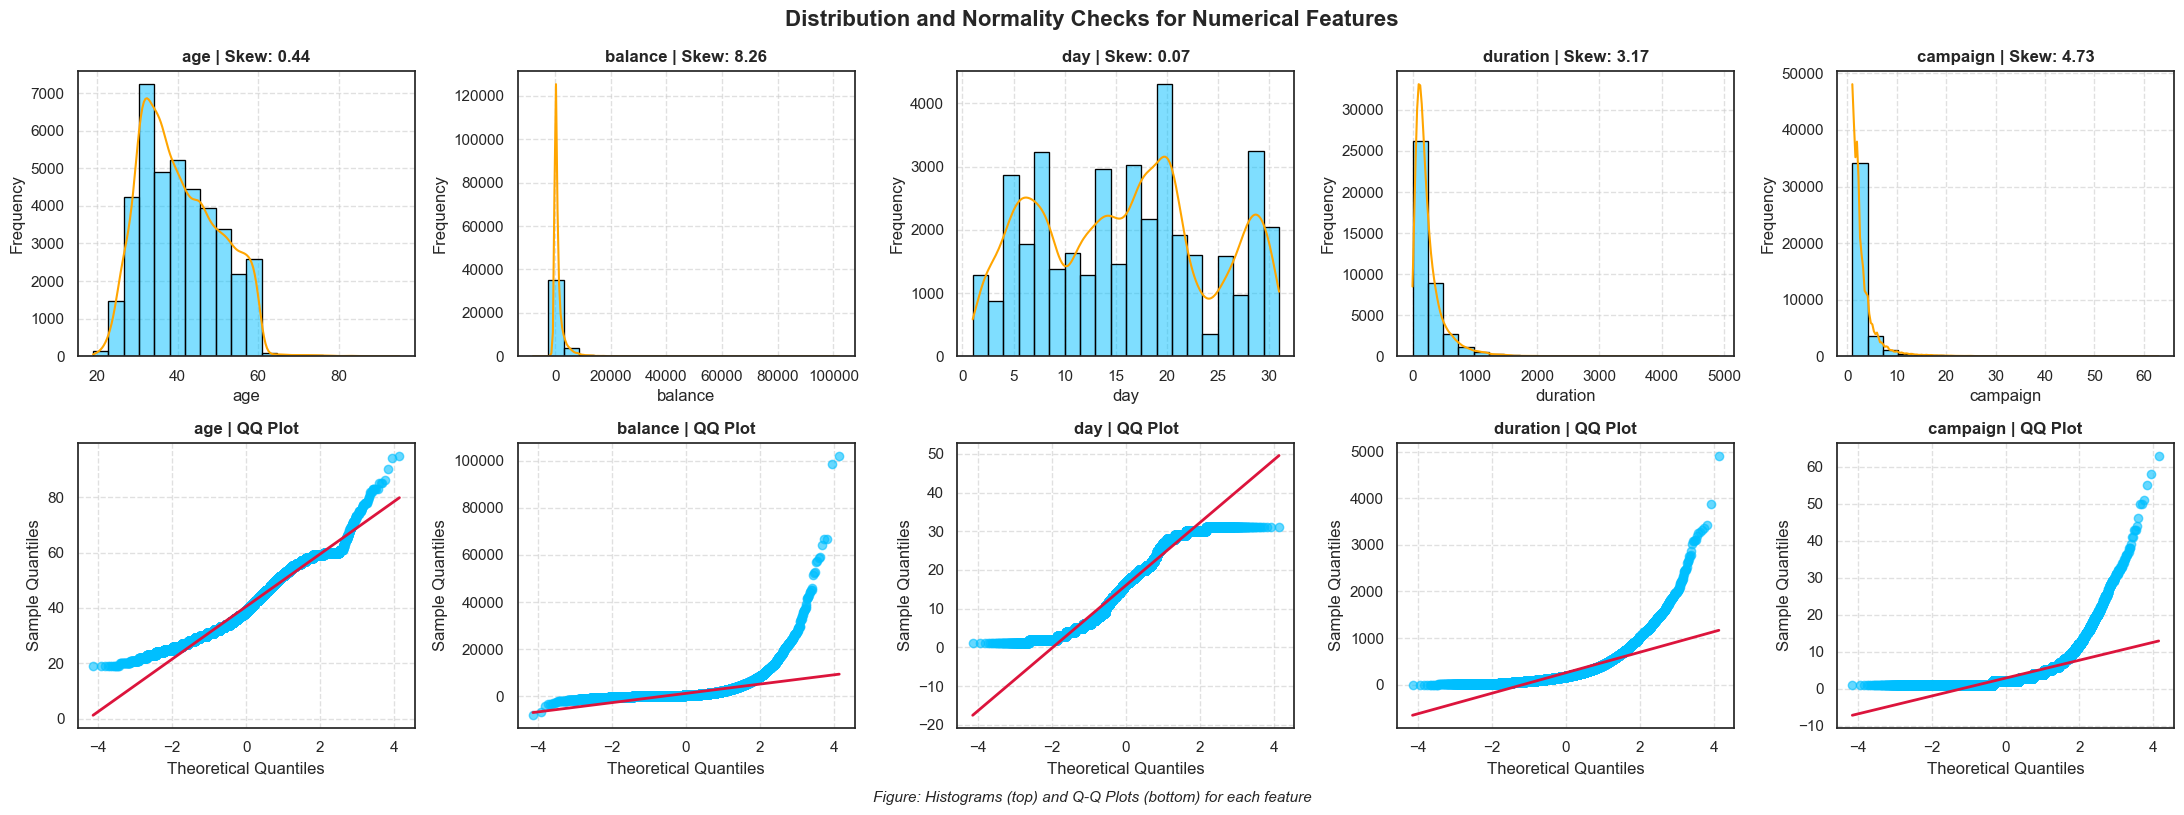

In [31]:
import scipy.stats as stats

# Updated function with bright blue QQ scatterpoints and custom KDE line
def check_skewness_and_qqplots(term_deposit, numerical_cols):
    sns.set_theme(style="white")
    fig, axes = plt.subplots(2,5, figsize=(22,8))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        skew_val = term_deposit[col].skew()

        # Histogram with KDE and custom colors
        sns.histplot(term_deposit[col], bins=20, kde=True, ax=axes[i],
                     color='deepskyblue', edgecolor='black', stat='count')

        # Modify KDE line color manually if present
        if axes[i].lines:
            axes[i].lines[0].set_color('orange')  # change KDE line color

        axes[i].set_title(f'{col} | Skew: {skew_val:.2f}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")
        axes[i].grid(True, linestyle='--', alpha=0.6)

        # QQ Plot with bright blue scatterpoints and crimson line
        (osm, osr), (slope, intercept, r) = stats.probplot(term_deposit[col], dist="norm")

        axes[i+5].scatter(osm, osr, color='deepskyblue', alpha=0.6)
        axes[i+5].plot(osm, slope * osm + intercept, color='crimson', linewidth=2)
        axes[i+5].set_title(f'{col} | QQ Plot', fontsize=12, fontweight='bold')
        axes[i+5].set_xlabel("Theoretical Quantiles")
        axes[i+5].set_ylabel("Sample Quantiles")
        axes[i+5].grid(True, linestyle='--', alpha=0.6)

    # Adjust layout
    fig.suptitle("Distribution and Normality Checks for Numerical Features", fontsize=16, fontweight='bold')
    #fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.text(0.5, -0.01, 'Figure: Histograms (top) and Q-Q Plots (bottom) for each feature', 
             ha='center', fontsize=11, style='italic')
    plt.tight_layout()
    plt.show()

# Run the customized function
check_skewness_and_qqplots(term_deposit, numerical_cols)

The following can be gleaned for each numerical feature from the prior plots:  

* **age**:  The age variable histogram shows a small tail to the right with a mild slightly positive (right-skewed) value. Age’s QQ plot has the deviated points curving upward confirming the data is right-skewed. Most customers are in their 30s or middle aged with a tail to older years. Interpretation leads to this variable being almost normal with no transformations needed.  

* **balance**: Feature *balance*’s skewness value is very high (~8.9) and its histogram shows a long right tail with many small values and a few large outliers. The feature is strongly right skewed and its QQ plot having heavy S-shaped deviations in upper quantiles. Interpretation of these plots leads to the consideration of using log transformation to reduce skewness before modeling. Most customers have small to moderate balances, but few customers have very large balances pulling the distribution’s tail far to the right.  

* **day**: This variable has little to no skewness. The distribution of the days is fairly uniform across the month, with no strong pattern or bias toward the beginning or end.  

* **duration**: This feature has most of its values concentrated on the left with a sharp right tail. It has a high right-skewed value. From its QQ plot, it has a severe deviation from normality at higher values. Most calls are short but there are a few calls that are very long. Logarithmic transformation will be done on this feature with a cap on long calls to prevent distorting models.  

* **campaign**: Campaign has a high right-sided skewness value where the majority of the clients were contacted a few times and a few outliers were contacted 10+ times. The QQ plot affirms outliers affect the upper quantities. Will cap the long outliers to prevent noise.   


#### Feature Distributions Categorical

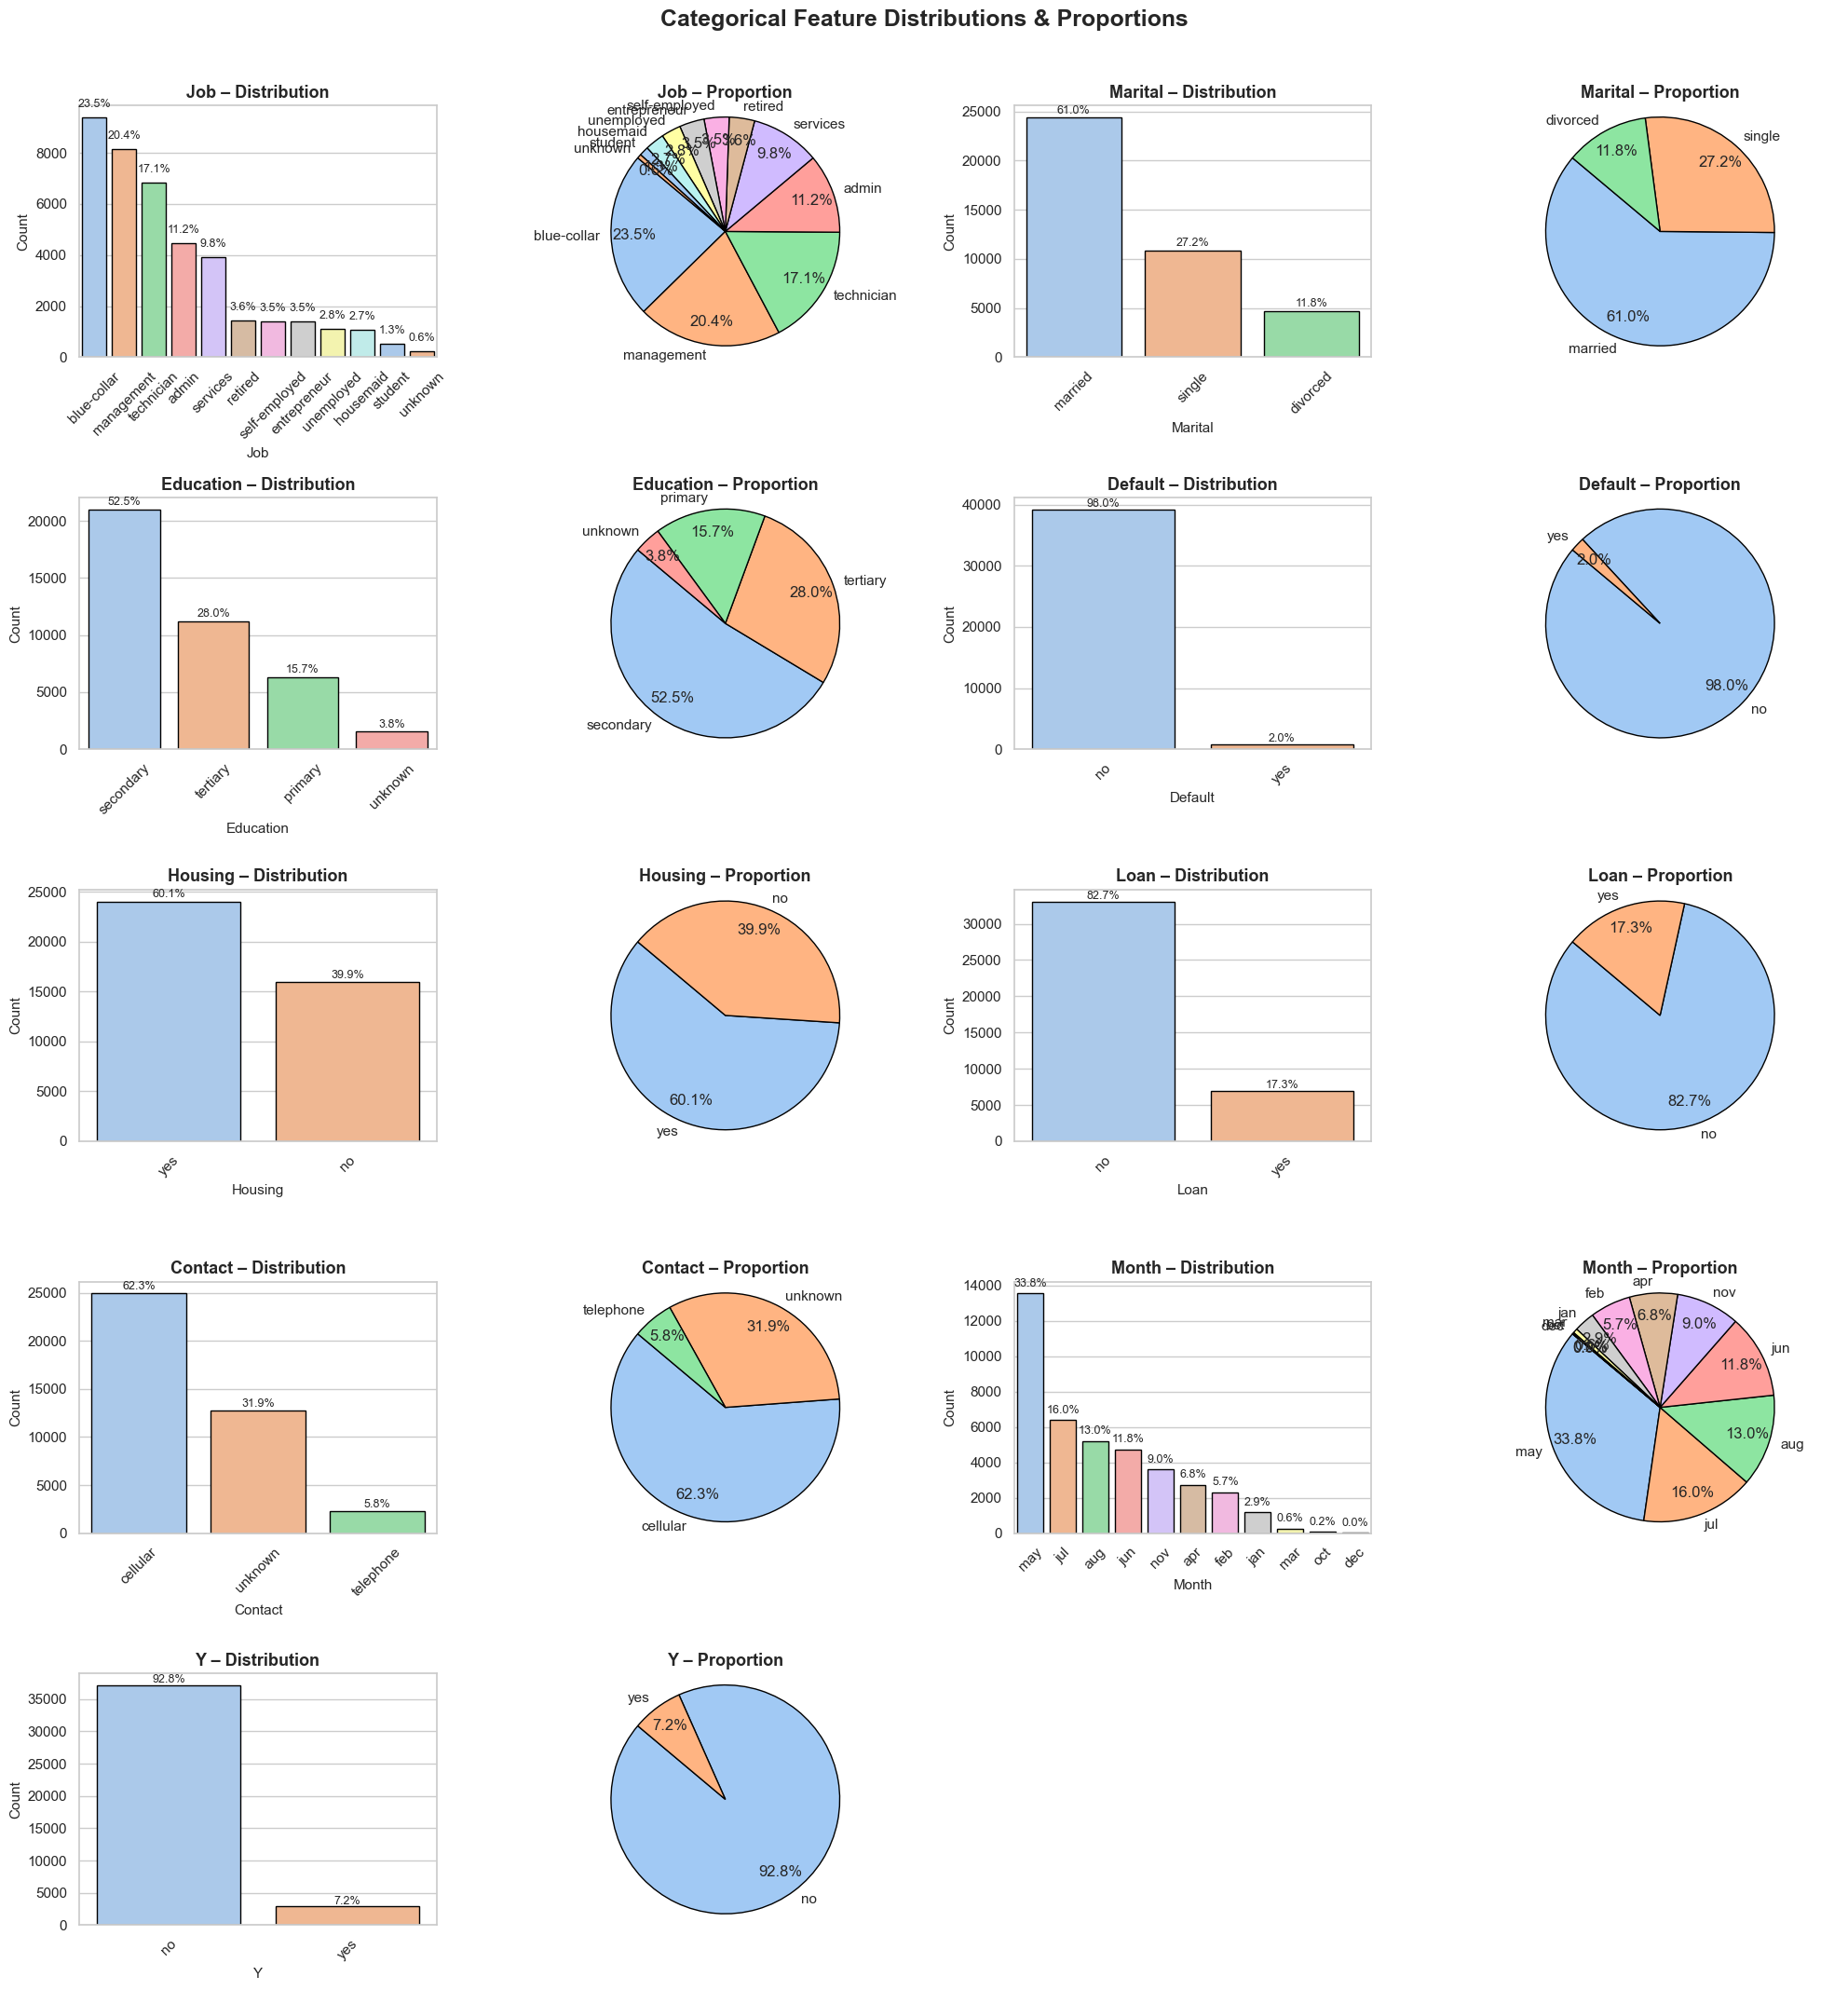

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')


# function to plot bar and pie charts for categorical features in the dataset
def plot_categorical_eda(term_deposit ,categorical_cols):
    """
    Plots bar and pie charts for categorical features in a 5x4 grid layout.
    Parameters:
    term_deposit : 
        The dataset containing categorical features.
    categorical_cols : 
        List of categorical column names to plot 
    """
    color_palette = sns.color_palette('pastel')
    # number of rows in dataset used to compute percentages
    total = len(term_deposit)
    num_features = len(categorical_cols)

    # Set up the 5x4 grid (each feature takes 2 plots: bar and pie)
    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 22))
    axes = axes.flatten()

    # Main Plotting Loop
    for i, col in enumerate(categorical_cols):
        # assign bar+pie plots next to each other, 
        bar_ax = axes[2*i]
        pie_ax = axes[2*i+1]

        # Count of each category, preprocessing per column
        value_counts = term_deposit[col].value_counts()
        percentages = (value_counts / total * 100).round(1)

        # Bar Plot Construction
        sns.countplot(
            data=term_deposit,
            x=col,
            order=value_counts.index,
            palette=color_palette,
            ax = bar_ax,
            edgecolor='black'
        )
        # Add percentage labesl above bars
        for j, count in enumerate(value_counts):
            bar_ax.text(j, count + total * 0.01, f'{(count / total * 100):.1f}%', 
                        ha='center', fontsize=9)
        bar_ax.set_title(f'{col.capitalize()} – Distribution', fontsize=13, fontweight='bold')
        bar_ax.set_xlabel(col.capitalize(), fontsize=11)
        bar_ax.set_ylabel("Count", fontsize=11)
        bar_ax.tick_params(axis='x', rotation=45)

        # ---- Pie Chart ----
        pie_ax.pie(
            value_counts,
            labels=value_counts.index,
            autopct='%1.1f%%',
            pctdistance=0.8,
            startangle=140,
            colors=color_palette,
            wedgeprops={'edgecolor': 'black'}
        )
        pie_ax.set_title(f'{col.capitalize()} – Proportion', fontsize=13, fontweight='bold')
        pie_ax.axis('equal')

    # Remove unused axes if any
    for idx in range(2 * num_features, len(axes)):
        fig.delaxes(axes[idx])

    fig.suptitle("Categorical Feature Distributions & Proportions", fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0.01, 1, 0.97])
    plt.show()
        
plot_categorical_eda(term_deposit, categorical_cols)

        





The following insights can be gleaned from the prior bar and pie charts of the categorical features: 
* **Y**: From the last plot, the distribution of the target variable is heavily imbalanced. Most customers did not subscribe to the term deposit with a subscription rate ~ 7%. Synthetic Minority Over-sampling Technique (SMOTE) will be utilized to handle the imbalance, and the evaluation metric will be adjusted to focus on F1-score instead of accuracy.  

* **Job**: The most common jobs are blue-collar, management, technician, admin and services. Students and retired customers are less frequent but are important as they often show higher subscription rates.

* **Marital**: Most customers are married (*61%*) followed by single and divorced. There is no major imbalance.

* **Education**: Over half of the customer base has a secondary level of education (*52.25%*), followed by tertiary, primary and lastly unknown. 

* **Default**: The vast majority of customers do not have default (96%). This feature is highly imbalanced.
 
* **Housing**: This feature is balanced, with ~60% of the customers having a housing loan. 

* **Loan**: Most customers do not have a personal loan (82.7%). This feature might be useful as having personal loans may impact financial flexibility.

* **Contact**: Majority of contact methods have been via cellular (623%) with unknown following and telephone having a small part. The unknown category is kept as it may indicate poor campaign reach.

* **Month**: From the plots, most calls are made in May, July, August and June. Months like January, March, October and December have very low marketing efforts. Seasonality is important and this feature will be cyclically encoded.


#### Detecting Outliers:  
Interquantile Range (IQR) was used to detect outliers for the numerical features. Many of the numerical features (balance, duration and campaign) are strongly skewed and not normally distributed from the histrogram and QQ plots. IQR focuses on the middle 50% of the data and ignores the extreme values on both ends. This makes it resistant to extreme outliers. 

In [36]:
# Outlier detection using IQR
# identifies and counts the number of outliers in each numerical column of the dataset using the Interquartile Range Method
def detect_outliers_iqr(term_deposit, numerical_cols):
    # compute the 25th and 75th percentile for each numerical column
    Q1 = term_deposit[numerical_cols].quantile(0.25)
    Q3 = term_deposit[numerical_cols].quantile(0.75)
    # calculates the Interquartile range "middle 50%"
    IQR = Q3 - Q1
    # threshold limits of an outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # checks for each column which rows fall outside the bounds
    outliers = ((term_deposit[numerical_cols] < lower_bound) | (term_deposit[numerical_cols] > upper_bound)).sum()
    print(outliers[outliers>0])
    

detect_outliers_iqr(term_deposit,numerical_cols)


age           79
balance     4280
duration    3000
campaign    2992
dtype: int64


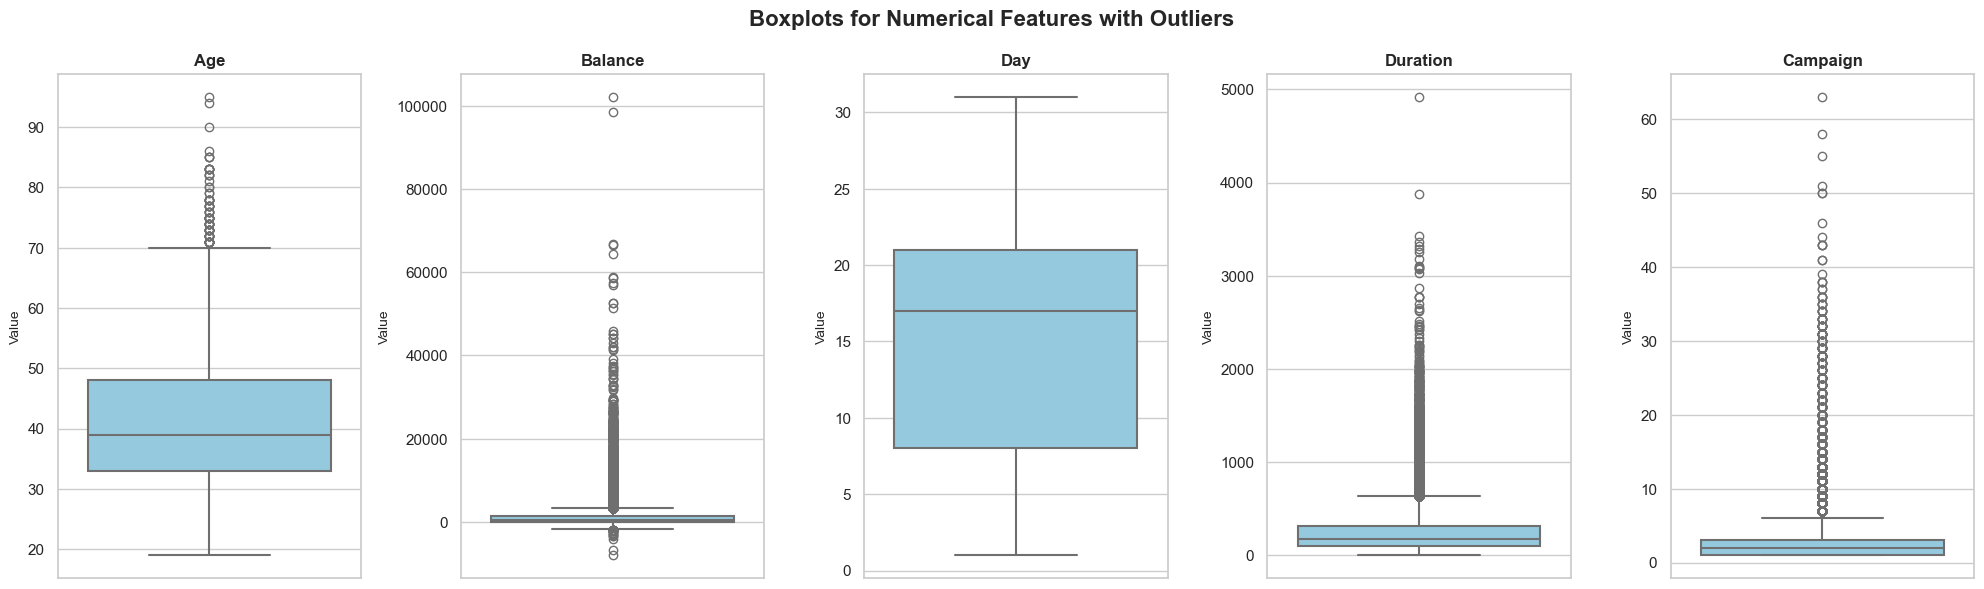

In [35]:
# boxplot visualizing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def boxplot_outliers(term_deposit, numerical_cols):
    sns.set_theme(style='whitegrid')
    
    #plt.figure(figsize=(8,4))
    num_features = len(numerical_cols)
    # create subplots, arrange boxplots horizontally (1 row, n columns)
    # each subplot is width 4, height 6, and sharey=False means each plot has it owns y-axis
    fig, axs = plt.subplots(1,num_features, figsize=(4 * num_features, 6), sharey=False)
    for i, num in enumerate(numerical_cols):
        sns.boxplot(y=term_deposit[num], ax=axs[i], color = 'skyblue', linewidth=1.5)
        axs[i].set_title(f"{num.capitalize()}", fontsize=12, fontweight='bold')
        axs[i].set_ylabel('Value', fontsize=10)
    fig.suptitle('Boxplots for Numerical Features with Outliers', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

boxplot_outliers(term_deposit, numerical_cols)

#### Overall Insights from numerical features boxplots
* Significant number of outliers in features: Balance, Duration and Campaign. These boxplots confirm from previous findings that these features will need transformation done to them. *Balance* contains negative values (overdrafts) which will be need to be shifted when log transformed as log transforming negative values produce NaN values which will crash machine learning models.
* The outliers in age are natural as there are older customers. Day has no significant outliers. 

### Preprocessing:  
##### One-hot Encoding to handle different data type features (categorical and numerical):  
One-hot encoding is a method to convert categorical features into a numerical format that machine learning models can utlizie. Simply assigning numbers to categories (e.g. job: 'staff' = 2, 'scientist' = 5) can mislead our ML models to think there is an ordinal relationship. The term deposit dataset shown above has 13 features and 40,000 data point of which 9 of the features are categorical. 


In [8]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def convert_object_features(df):
    df = df.copy()

    # Exclude the target variable
    object_cols = df.select_dtypes(include='object')

    # Define binary and categorical features
    binary_features = []
    categorical_features = []

    for col in object_cols:
        unique_vals = df[col].nunique()
        if unique_vals == 2:
            binary_features.append(col)
        else:
            categorical_features.append(col)

    # Convert binary features to 0/1
    for col in binary_features:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col]).astype('int64')

    # converting categorical features to dummy variables
    df[categorical_features] = df[categorical_features].astype('category')

    return df

term_deposit_changed = convert_object_features(term_deposit)
term_deposit_changed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        40000 non-null  int64   
 1   job        40000 non-null  category
 2   marital    40000 non-null  category
 3   education  40000 non-null  category
 4   default    40000 non-null  int64   
 5   balance    40000 non-null  int64   
 6   housing    40000 non-null  int64   
 7   loan       40000 non-null  int64   
 8   contact    40000 non-null  category
 9   day        40000 non-null  int64   
 10  month      40000 non-null  category
 11  duration   40000 non-null  int64   
 12  campaign   40000 non-null  int64   
 13  y          40000 non-null  int64   
dtypes: category(5), int64(9)
memory usage: 2.9 MB


In [54]:
def print_columns_with_unknowns(df):
    for col in df.columns:
        if 'unknown' in df[col].values:
            count = (df[col] == 'unknown').sum()
            percentage = round(count / df.shape[0] * 100, 2)
            print('-----------------------------------')
            print(f"{col} : {count}")
            print(f"Percentage of unknown values in {col} : {percentage}%")
            print(f"Unique values of {col} : {df[col].unique()}")

print_columns_with_unknowns(term_deposit_changed)

In [49]:
def handle_unknown_values(df, lower_thresh=5.0, upper_thresh=30.0):
    df = df.copy()
    total_rows = df.shape[0]

    for col in df.columns:
        if 'unknown' in df[col].values:
            unknown_count = (df[col] == 'unknown').sum()
            unknown_pct = unknown_count / total_rows * 100

            if unknown_pct < lower_thresh:
                df = df[df[col] != 'unknown']  # Drop rows
            elif unknown_pct <= upper_thresh:
                # Impute with mode
                mode_val = df[col].mode()[0]
                df[col] = df[col].replace('unknown', mode_val)
            else:
                # Optionally drop column if unknowns are too frequent
                df.drop(columns=col, inplace=True)

    return df


term_deposit_changed = handle_unknown_values(term_deposit_changed)

In [55]:
term_deposit_changed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38338 entries, 0 to 39999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        38338 non-null  int64   
 1   job        38338 non-null  category
 2   marital    38338 non-null  category
 3   education  38338 non-null  category
 4   default    38338 non-null  int64   
 5   balance    38338 non-null  int64   
 6   housing    38338 non-null  int64   
 7   loan       38338 non-null  int64   
 8   day        38338 non-null  int64   
 9   month      38338 non-null  category
 10  duration   38338 non-null  int64   
 11  campaign   38338 non-null  int64   
 12  y          38338 non-null  int64   
dtypes: category(4), int64(9)
memory usage: 3.1 MB


In [58]:
import numpy as np

def encode_categorical_features(df):
    df = df.copy()

    # Ordinal encoding for 'education'
    education_order = ['primary', 'secondary', 'tertiary']
    df['education'] = df['education'].astype(pd.api.types.CategoricalDtype(categories=education_order, ordered=True))
    df['education'] = df['education'].cat.codes

    # Label encode 'job' and 'marital'
    for col in ['job', 'marital']:
        df[col] = df[col].astype('category').cat.codes

    # Convert 'month' from categorical to string before mapping
    df['month'] = df['month'].astype(str).str.lower()
    month_map = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
        'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
        'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }
    df['month'] = df['month'].map(month_map).astype(int)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df.drop(columns='month', inplace=True)

    return df

term_deposit_changed_v2 = encode_categorical_features(term_deposit_changed)

In [59]:
term_deposit_changed_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38338 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        38338 non-null  int64  
 1   job        38338 non-null  int8   
 2   marital    38338 non-null  int8   
 3   education  38338 non-null  int8   
 4   default    38338 non-null  int64  
 5   balance    38338 non-null  int64  
 6   housing    38338 non-null  int64  
 7   loan       38338 non-null  int64  
 8   day        38338 non-null  int64  
 9   duration   38338 non-null  int64  
 10  campaign   38338 non-null  int64  
 11  y          38338 non-null  int64  
 12  month_sin  38338 non-null  float64
 13  month_cos  38338 non-null  float64
dtypes: float64(2), int64(9), int8(3)
memory usage: 3.6 MB


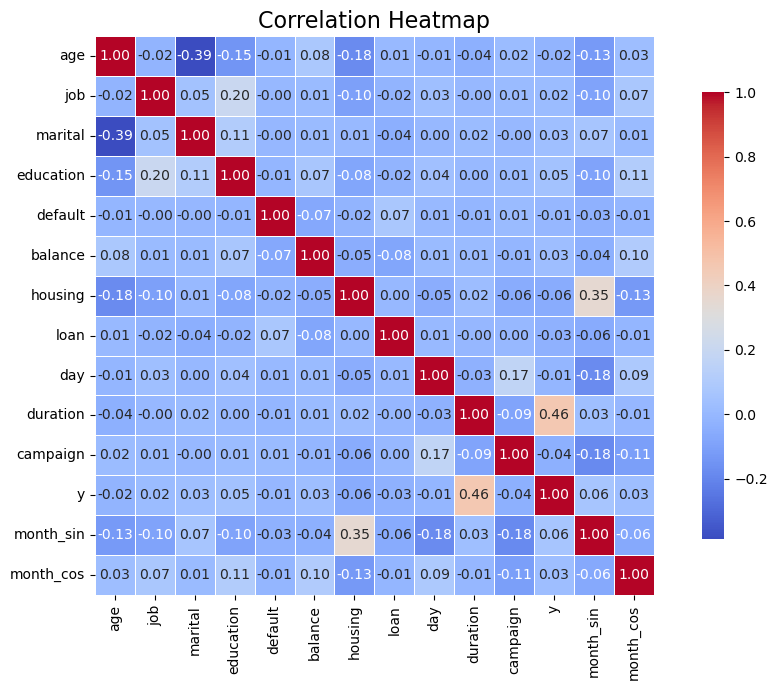

In [60]:

# heatmap ofr 
def heatmap_new(term_deposit):
    correlation_deposit = term_deposit.copy()
    correlation_matrix = correlation_deposit.corr()
    fig, ax = plt.subplots(figsize=(10,7))

    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        linewidth=0.5,
        square=True,
        cbar_kws={'shrink':0.8},
        ax=ax
        )
    # Set Title
    ax.set_title("Correlation Heatmap", fontsize=16)
    # Adjust layout to prevent clipping
    fig.tight_layout()
    # Show plot
    plt.show()
heatmap_new(term_deposit_changed_v2)

In [62]:
term_deposit_changed_v2 = term_deposit_changed_v2.drop(['default', 'day'], axis=1)
term_deposit_changed_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38338 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        38338 non-null  int64  
 1   job        38338 non-null  int8   
 2   marital    38338 non-null  int8   
 3   education  38338 non-null  int8   
 4   balance    38338 non-null  int64  
 5   housing    38338 non-null  int64  
 6   loan       38338 non-null  int64  
 7   duration   38338 non-null  int64  
 8   campaign   38338 non-null  int64  
 9   y          38338 non-null  int64  
 10  month_sin  38338 non-null  float64
 11  month_cos  38338 non-null  float64
dtypes: float64(2), int64(7), int8(3)
memory usage: 4.0 MB


In [63]:
def cap_outliers_iqr(series, name=None):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    capped = np.clip(series, lower, upper)
    if name:
        num_capped = ((series < lower) | (series > upper)).sum()
        print(f"{name}: {num_capped} values capped using IQR.")
    return capped

def transform_skewed_features(df):
    df = df.copy()

    # Shift balance to ensure positivity for log transformation
    if (df['balance'] <= 0).any():
        df['balance'] = df['balance'] + abs(df['balance'].min()) + 1
    df['balance'] = np.log(df['balance'])

    # Log-transform duration
    df['duration'] = np.log(df['duration'] + 1)

    # Cap campaign at 10, then log-transform
    df['campaign'] = np.where(df['campaign'] > 10, 10, df['campaign'])
    df['campaign'] = np.log(df['campaign'] + 1)

    # Cap outliers after log transformations
    df['balance'] = cap_outliers_iqr(df['balance'], name='balance')
    df['duration'] = cap_outliers_iqr(df['duration'], name='duration')
    df['campaign'] = cap_outliers_iqr(df['campaign'], name='campaign')

    return df

term_deposit_changed_v3 = transform_skewed_features(term_deposit_changed_v2)

balance: 3592 values capped using IQR.
duration: 962 values capped using IQR.
campaign: 0 values capped using IQR.


In [64]:
term_deposit_changed_v3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38338 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        38338 non-null  int64  
 1   job        38338 non-null  int8   
 2   marital    38338 non-null  int8   
 3   education  38338 non-null  int8   
 4   balance    38338 non-null  float64
 5   housing    38338 non-null  int64  
 6   loan       38338 non-null  int64  
 7   duration   38338 non-null  float64
 8   campaign   38338 non-null  float64
 9   y          38338 non-null  int64  
 10  month_sin  38338 non-null  float64
 11  month_cos  38338 non-null  float64
dtypes: float64(5), int64(4), int8(3)
memory usage: 4.0 MB


In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def preprocess_term_deposit(term_deposit, numerical_cols, categorical_cols):
    """
    Preprocess the Term Deposit Marketing Dataset based on prior EDA findings:
    Steps:
    - Encode the categorical featues (Label Encode for binary and One-Hot Encode for nominal using sklearn)
    - Log-transform skewed numerical variables
    - Cap extreme campaign values
    - Apply cyclical encoding to month feature
    - Save transformed dataset to a CSV file
    Returns: features X and target Y
    """
    term_deposit = term_deposit.copy()

    # Drop rows with 'unknown' in critical nominal categorical features
    unknown_sensitive_cols = ['job', 'education', 'contact']  # modify based on your domain
    for col in unknown_sensitive_cols:
        if col in term_deposit.columns:
            term_deposit = term_deposit[term_deposit[col].str.lower() != 'unknown']


    categorical_cols = categorical_cols.drop('y', errors='ignore')

    # Target encoding, converting binary target (y) from ('yes', 'no') into (1,0)
    term_deposit['y'] = term_deposit['y'].map({'yes':1, 'no':0})

    # Separate Independent and Target Features
    y = term_deposit['y']
    term_deposit = term_deposit.drop('y', axis=1)   # Remove y to prevent it from being transformed

    # Log Transformation on skewed Numerical Featrues (balance & duration)
    # Balance has negative values, need to shift values to log transform them
    if 'balance' in term_deposit.columns:
        min_balance = term_deposit['balance'].min()
        shift_value = abs(min_balance) + 1 if min_balance <= -1 else 0
        term_deposit['balance'] = np.log1p(term_deposit['balance'] + shift_value)

    # Log transform duration
    if 'duration' in term_deposit.columns:
        term_deposit['duration'] = np.log1p(term_deposit['duration'])
    
    # Cap extreme values for campaign, cap number of times client contacted in campaign at 10
    if 'campaign' in term_deposit.columns:
        term_deposit['campaign'] = np.where(term_deposit['campaign'] > 10, 10, term_deposit['campaign'])

    # Label Encode Binary Categorical Features
    binary_features = ['default', 'housing', 'loan']
    for col in binary_features:
        if col in term_deposit.columns:
            term_deposit[col] = term_deposit[col].map({'yes':1, 'no':0})

    # Cyclical Encoding for 'month' Feature
    if 'month' in term_deposit.columns:
        month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
        term_deposit['month_num'] = term_deposit['month'].str.lower().map({m: i+1 for i, m in enumerate(month_order)})
        term_deposit['month_sin'] = np.sin(2 * np.pi * term_deposit['month_num'] / 12)
        term_deposit['month_cos'] = np.cos(2 * np.pi * term_deposit['month_num'] / 12)
        term_deposit.drop(['month', 'month_num'], axis=1, inplace=True)

    # One-Hot Encode Nominal Categorical Features
    # First filter only multi-class nominal features
    nominal_features = [col for col in categorical_cols if col not in binary_features and col != 'month' and term_deposit[col].dtype == 'object']

    # Apply OneHotEncoder onto nominal_features, using sklearn
    encoder = ColumnTransformer(
        transformers=[
            # Drop first category to avoid multicollinearity, returns a dense array and keeps all non-encoded columns
            ('onehot', OneHotEncoder(drop='first', sparse_output=False), nominal_features),
            ('scale', StandardScaler(), numerical_cols)
        ],
        remainder='passthrough'
    )

    # Apply the transformation using the defined pipeline
    transformed_term_deposit = encoder.fit_transform(term_deposit)
    # Get cleaned feature names by manually renaming columns after transformation
    feature_names = encoder.get_feature_names_out()
    feature_names = [name.split('__')[-1] for name in feature_names]
    transformed_term_deposit = pd.DataFrame(transformed_term_deposit, columns=feature_names)

    # Save the processed data
    processed_term = transformed_term_deposit.copy()
    processed_term['y'] = y.values
    output_path = '../data/interim/processed_term_deposit.csv'
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    processed_term.to_csv(output_path, index=False)
    
    X = transformed_term_deposit.copy()
    return X, y

X, y = preprocess_term_deposit(term_deposit, numerical_cols, categorical_cols)

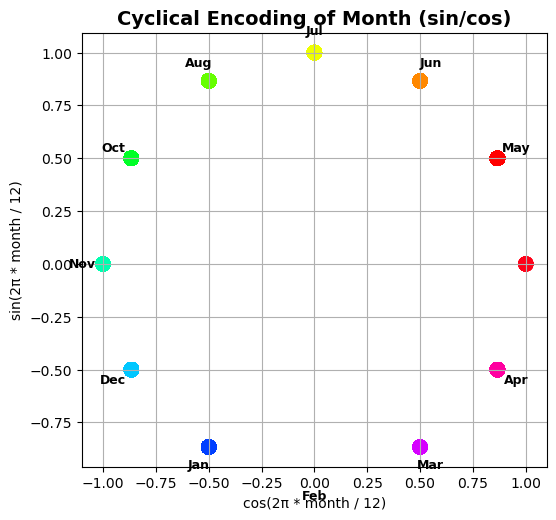

In [29]:
import matplotlib.pyplot as plt

def plot_month_cyclical_encoding(term_deposit):
    # Ensure month has not been dropped yet
    month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                   'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    term_deposit['month_num'] = term_deposit['month'].str.lower().map({m: i+1 for i, m in enumerate(month_order)})
    term_deposit['month_sin'] = np.sin(2 * np.pi * term_deposit['month_num'] / 12)
    term_deposit['month_cos'] = np.cos(2 * np.pi * term_deposit['month_num'] / 12)

    plt.figure(figsize=(6,6))
    plt.scatter(term_deposit['month_cos'], term_deposit['month_sin'], c=term_deposit['month_num'], cmap='hsv', s=100)
    
    for i, txt in enumerate(term_deposit['month'].unique()):
        angle = 2 * np.pi * (i + 1) / 12
        x = np.cos(angle)
        y = np.sin(angle)
        plt.text(x * 1.1, y * 1.1, txt.capitalize(), ha='center', va='center', fontsize=9, weight='bold')
    
    plt.title('Cyclical Encoding of Month (sin/cos)', fontsize=14, fontweight='bold')
    plt.xlabel('cos(2π * month / 12)')
    plt.ylabel('sin(2π * month / 12)')
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

plot_month_cyclical_encoding(term_deposit)

In [18]:
def drop_low_correlation_features(X, y, threshold=0.003):
    """
    Drops features from X_train that have low linear correlation with the target variable.
    
    Parameters:
    - X_train (pd.DataFrame): Feature data
    - y_train (pd.Series): Target variable
    - threshold (float): Minimum absolute correlation value to keep a feature
    
    Returns:
    - X_filtered (pd.DataFrame): X_train with low-correlation features removed
    - dropped_features (list): Names of features that were removed
    """
    # Combine features and target
    df = X.copy()
    df['target'] = y

    # Compute correlation matrix
    corr_matrix = df.corr()
    target_corr = corr_matrix['target'].drop('target')  # drop self-correlation

    # Identify low-correlation features
    low_corr_features = target_corr[(-threshold < target_corr) & (target_corr < threshold)].index.tolist()

    # Drop them from X_train
    X_filtered = X.drop(columns=low_corr_features)

    print(f"Dropped {len(low_corr_features)} features with |correlation| < {threshold}:")
    print(low_corr_features)

    return X_filtered, low_corr_features

X_filtered, low_corr_features = drop_low_correlation_features(X, y)

Dropped 10 features with |correlation| < 0.003:
['job_retired', 'marital_single', 'education_secondary', 'education_tertiary', 'contact_telephone', 'age', 'balance', 'default', 'loan', 'month_cos']


### Train/Test Split Transformed Dataset


In [77]:
from sklearn.model_selection import train_test_split


X = term_deposit_changed_v3.drop(columns='y')
y = term_deposit_changed_v3['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

### Feature Selection: Combining Statistical, Model-based, and Wrapper Methods

In any supervised machine learning task, selecting the most relevant features is essential for building performant and interpretable models. In this project, we employed a multi-pronged feature selection strategy encompassing filter, embedded, and wrapper methods to robustly identify the features most predictive of customer subscription to a term deposit.

1. Mutual Information (Filter Method)
Mutual Information measures the amount of information one variable provides about another. Unlike linear methods, it can detect non-linear dependencies between features and the target.

We used mutual_info_classif from scikit-learn, which estimates the mutual information between each feature and the binary target (yes or no subscription), helping us prioritize variables that share the most information with the outcome — even in complex, non-linear ways.

2. ANOVA F-Test (Filter Method)
The Analysis of Variance (ANOVA) F-test evaluates the degree to which the means of different groups (in this case, subscribers vs. non-subscribers) vary across feature values. It assumes a linear relationship between each feature and the target and is ideal for selecting features when using linear classifiers.

We used SelectKBest with f_classif, which ranks features based on their F-scores — a statistical measure of between-group vs. within-group variability.

3. L1-Regularized Logistic Regression (Embedded Method)
L1 regularization (also known as Lasso) not only penalizes large weights but also drives less informative feature coefficients to zero — effectively eliminating them. This is an embedded method, meaning the feature selection is part of the model training itself.

By fitting a logistic regression with an L1 penalty, we captured a sparse linear model, identifying which features most strongly contribute to the model’s predictive power.

4. Random Forest Feature Importance (Embedded Method)
Random Forests are ensembles of decision trees that naturally produce feature importances based on Gini impurity reduction — essentially quantifying how much each feature decreases node uncertainty when splitting.

This method is particularly effective in handling non-linearities and interactions between features, making it ideal in real-world datasets like ours with both numerical and categorical data.

5. XGBoost Feature Importance (Embedded Method)
XGBoost is a gradient-boosted tree algorithm that builds an ensemble of trees in a sequential fashion. Like Random Forests, it offers a native importance metric, but is often more aggressive in pruning irrelevant features and handling class imbalance.

We used its gain-based importance scores to identify features that contribute the most to reducing the model's prediction error.

6. Recursive Feature Elimination (Wrapper Method)
Unlike the above methods that evaluate features individually, Recursive Feature Elimination (RFE) considers the interactions between features by training a model iteratively and pruning the least important feature at each step.

We used RFE with Logistic Regression to perform backward elimination, selecting the best-performing subset of features through repeated model training and scoring.

Why Use Multiple Methods?
Each method captures a different notion of "importance":

Filter methods rank features independently of any model.

Embedded methods perform selection during model training.

Wrapper methods optimize feature subsets based on model performance.

By combining these, we gained a well-rounded understanding of which features truly drive customer decision-making.





In [88]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from xgboost import XGBClassifier

def feature_selection(X_train, y_train):
    feature_names = X_train.columns     # extract feature names
    results = pd.DataFrame(index=feature_names)     # initialize empty Dataframe with feature names as index to store scores for each selection method

    # Filter methods, rely on statisitcal characteristics of the data, independent of any model
    # Compute Mutual Information between features and target
    mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
    results['Mutual_Info'] = pd.Series(mi_scores, index=feature_names)

    # Compute ANOVA F-test scores, selects features using univariate linear regression F-stats
    #  Evaluate if group means for the feature differ significiantly between target classes
    f_test = SelectKBest(score_func=f_classif, k='all')
    f_test.fit(X_train, y_train)
    results['ANOVA_F_test'] = pd.Series(f_test.scores_, index = feature_names)
    #---------------------------------------------------------------------------------------------------------------------

    # Wrapper Method, evaluate feature subset based on model performance
    # Recursive Feature Elimination 
    recursive_feature_elimination = RFE(estimator=LogisticRegression(solver='liblinear', random_state=42), n_features_to_select=20)
    recursive_feature_elimination.fit(X_train, y_train)
    results['RFE_selected'] = recursive_feature_elimination.support_.astype(int)
    #---------------------------------------------------------------------------------------------------------------------

    # Embedded Method
    # L1 Regularization (Lasso), train data on Logistic Regression with L1 regularization
    # storing absolute value of each coef as the importance score
    lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
    lasso.fit(X_train, y_train)
    results['Lasso_coef'] = pd.Series(np.abs(lasso.coef_).flatten(), index=feature_names)

    # Random Forest Feature Importance
    random_forest = RandomForestClassifier(n_estimators=100,random_state=42)
    # Train random forest and store Gini-based importance scores, reflecting how useful each feature was across trees
    random_forest.fit(X_train, y_train)
    results['RF_importance'] = pd.Series(random_forest.feature_importances_, index=feature_names)

    # XGBoost Feature Importance
    # Initialize XGBoost classifier, train on dataset and extract feature importance scores
    xg_Boost = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xg_Boost.fit(X_train, y_train)
    results['XGB_importance'] = pd.Series(xg_Boost.feature_importances_, index=feature_names)

    # Rank each column (higher = more important)
    for col in results.columns:
        if col != 'RFE_selected':
            results[f'{col}_rank'] = results[col].rank(ascending=False)

    return results.sort_values('Mutual_Info', ascending=False)



feature_selection_results = feature_selection(X_train, y_train)

LogisticRegression - Features: 1, f1: 0.2487
LogisticRegression - Features: 2, f1: 0.2751
LogisticRegression - Features: 3, f1: 0.2914
LogisticRegression - Features: 4, f1: 0.2885
LogisticRegression - Features: 5, f1: 0.2854
LogisticRegression - Features: 6, f1: 0.2866
LogisticRegression - Features: 7, f1: 0.2837
LogisticRegression - Features: 8, f1: 0.2826
LogisticRegression - Features: 9, f1: 0.2850
LogisticRegression - Features: 10, f1: 0.2840
LogisticRegression - Features: 11, f1: 0.2828
XGBoost - Features: 1, f1: 0.3745
XGBoost - Features: 2, f1: 0.3889
XGBoost - Features: 3, f1: 0.3903
XGBoost - Features: 4, f1: 0.4353
XGBoost - Features: 5, f1: 0.4387
XGBoost - Features: 6, f1: 0.4202
XGBoost - Features: 7, f1: 0.4305
XGBoost - Features: 8, f1: 0.4222
XGBoost - Features: 9, f1: 0.4341
XGBoost - Features: 10, f1: 0.4317
XGBoost - Features: 11, f1: 0.4256


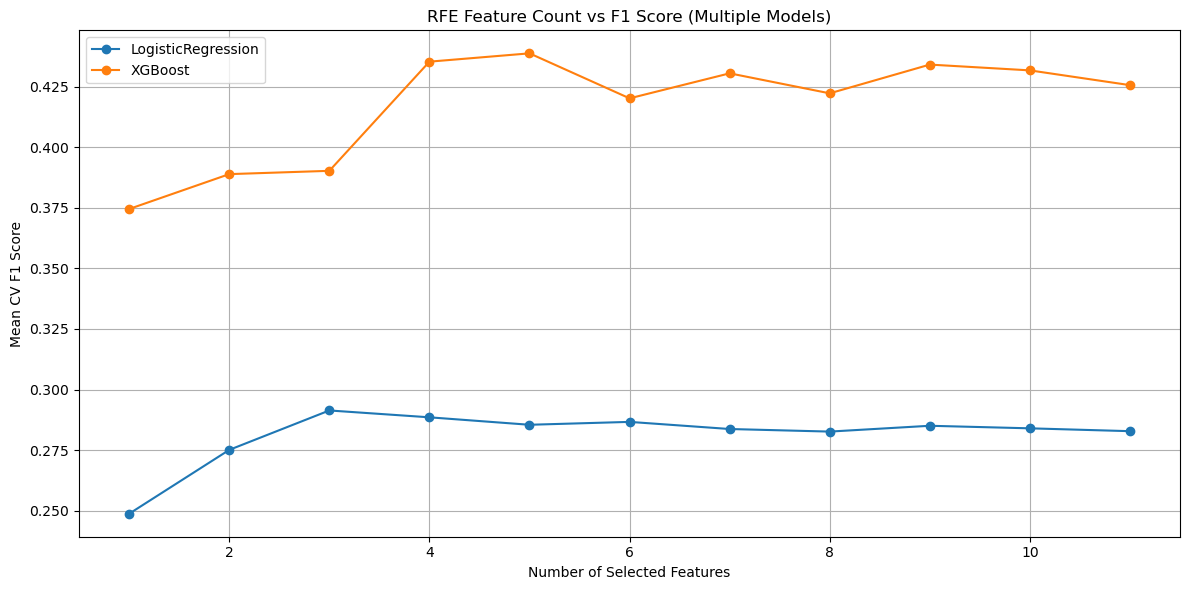

In [90]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def evaluate_rfe_feature_counts(X_train, y_train, estimators=None, max_features=None, step=1, cv=5, scoring='f1'):
    """
    Evaluates model performance using RFE across different numbers of features for multiple estimators.

    Parameters:
    - X_train: DataFrame of training features
    - y_train: Series of training labels
    - estimators: dictionary of estimators to test (default: LogisticRegression, RandomForest, XGBClassifier)
    - max_features: maximum number of features to test (default: all)
    - step: step size for number of features
    - cv: number of cross-validation folds
    - scoring: scoring metric (default: 'f1')

    Returns:
    - DataFrame summarizing scores for each estimator and feature count
    """
    if estimators is None:
        estimators = {
            'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42),
            #'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
            'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
        }

    if max_features is None:
        max_features = X_train.shape[1]

    feature_range = list(range(step, max_features + 1, step))
    results = []

    for name, estimator in estimators.items():
        scores = []
        for n_features in feature_range:
            rfe = RFE(estimator=estimator, n_features_to_select=n_features)
            X_rfe = rfe.fit_transform(X_train, y_train)
            score = cross_val_score(estimator, X_rfe, y_train, cv=cv, scoring=scoring).mean()
            scores.append(score)
            print(f"{name} - Features: {n_features}, {scoring}: {score:.4f}")
        results.append(pd.DataFrame({
            'n_features': feature_range,
            f'{scoring}_score': scores,
            'model': name
        }))

    result_df = pd.concat(results, ignore_index=True)

    # Plotting
    plt.figure(figsize=(12, 6))
    for name in estimators:
        model_df = result_df[result_df['model'] == name]
        plt.plot(model_df['n_features'], model_df[f'{scoring}_score'], marker='o', label=name)

    plt.title(f'RFE Feature Count vs {scoring.upper()} Score (Multiple Models)')
    plt.xlabel('Number of Selected Features')
    plt.ylabel(f'Mean CV {scoring.upper()} Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


evaluate_rfe_feature_counts(X_train, y_train)


In [89]:
feature_selection_results.style \
    .set_caption("Feature Selection Summary") \
    .set_table_styles([
        {
            'selector': 'caption',
            'props': [('caption-side', 'top'), ('font-size', '14pt'), ('font-weight', 'bold'), ('text-align', 'left')]
        },
        {
            'selector': 'th',
            'props': [('font-size', '11pt'), ('text-align', 'center'), ('font-weight', 'bold')]
        },
        {
            'selector': 'td',
            'props': [('font-size', '10pt'), ('text-align', 'center')]
        }
    ]) \
    .format({col: "{:.6f}" for col in feature_selection_results.columns
             if col not in ["Mutual_Info_rank", "ANOVA_F_test_rank", "Lasso_coef_rank",
                            "RF_importance_rank", "XGB_importance_rank"]}) \
    .format({
        col: "{:.0f}" for col in [
            "Mutual_Info_rank", "ANOVA_F_test_rank", "Lasso_coef_rank",
            "RF_importance_rank", "XGB_importance_rank"
        ]
    }) \
    .background_gradient(
        cmap='Blues_r', axis=0,
        subset=["Mutual_Info_rank", "ANOVA_F_test_rank", "Lasso_coef_rank",
                "RF_importance_rank", "XGB_importance_rank"]
    ) \
    .background_gradient(
        cmap='Blues', axis=0,
        subset=[col for col in feature_selection_results.columns
                if col not in ["Mutual_Info_rank", "ANOVA_F_test_rank", "Lasso_coef_rank",
                               "RF_importance_rank", "XGB_importance_rank"]]
    )


,Mutual_Info,ANOVA_F_test,RFE_selected,Lasso_coef,RF_importance,XGB_importance,Mutual_Info_rank,ANOVA_F_test_rank,Lasso_coef_rank,RF_importance_rank,XGB_importance_rank
duration,0.078561,4761.158948,1,2.195290,0.418006,0.268286,1,1,1,1,1
month_cos,0.011522,32.925029,1,0.095742,0.038974,0.084992,2,9,8,7,4
month_sin,0.011006,119.460660,1,0.644006,0.057872,0.199788,3,2,3,5,2
housing,0.007565,114.533302,1,0.879738,0.020646,0.118271,4,4,2,10,3
job,0.004821,12.070473,1,0.006473,0.064111,0.044574,5,11,10,4,8
balance,0.004551,115.367851,1,0.596966,0.146791,0.043926,6,3,4,2,9
age,0.004264,13.956235,1,0.001476,0.129908,0.041951,7,10,11,3,11
campaign,0.002648,68.678289,1,0.220522,0.052680,0.043111,8,6,7,6,10
education,0.002297,76.594526,1,0.294784,0.028799,0.055171,9,5,6,8,5
marital,0.002182,34.839521,1,0.085098,0.028074,0.050473,10,8,9,9,6


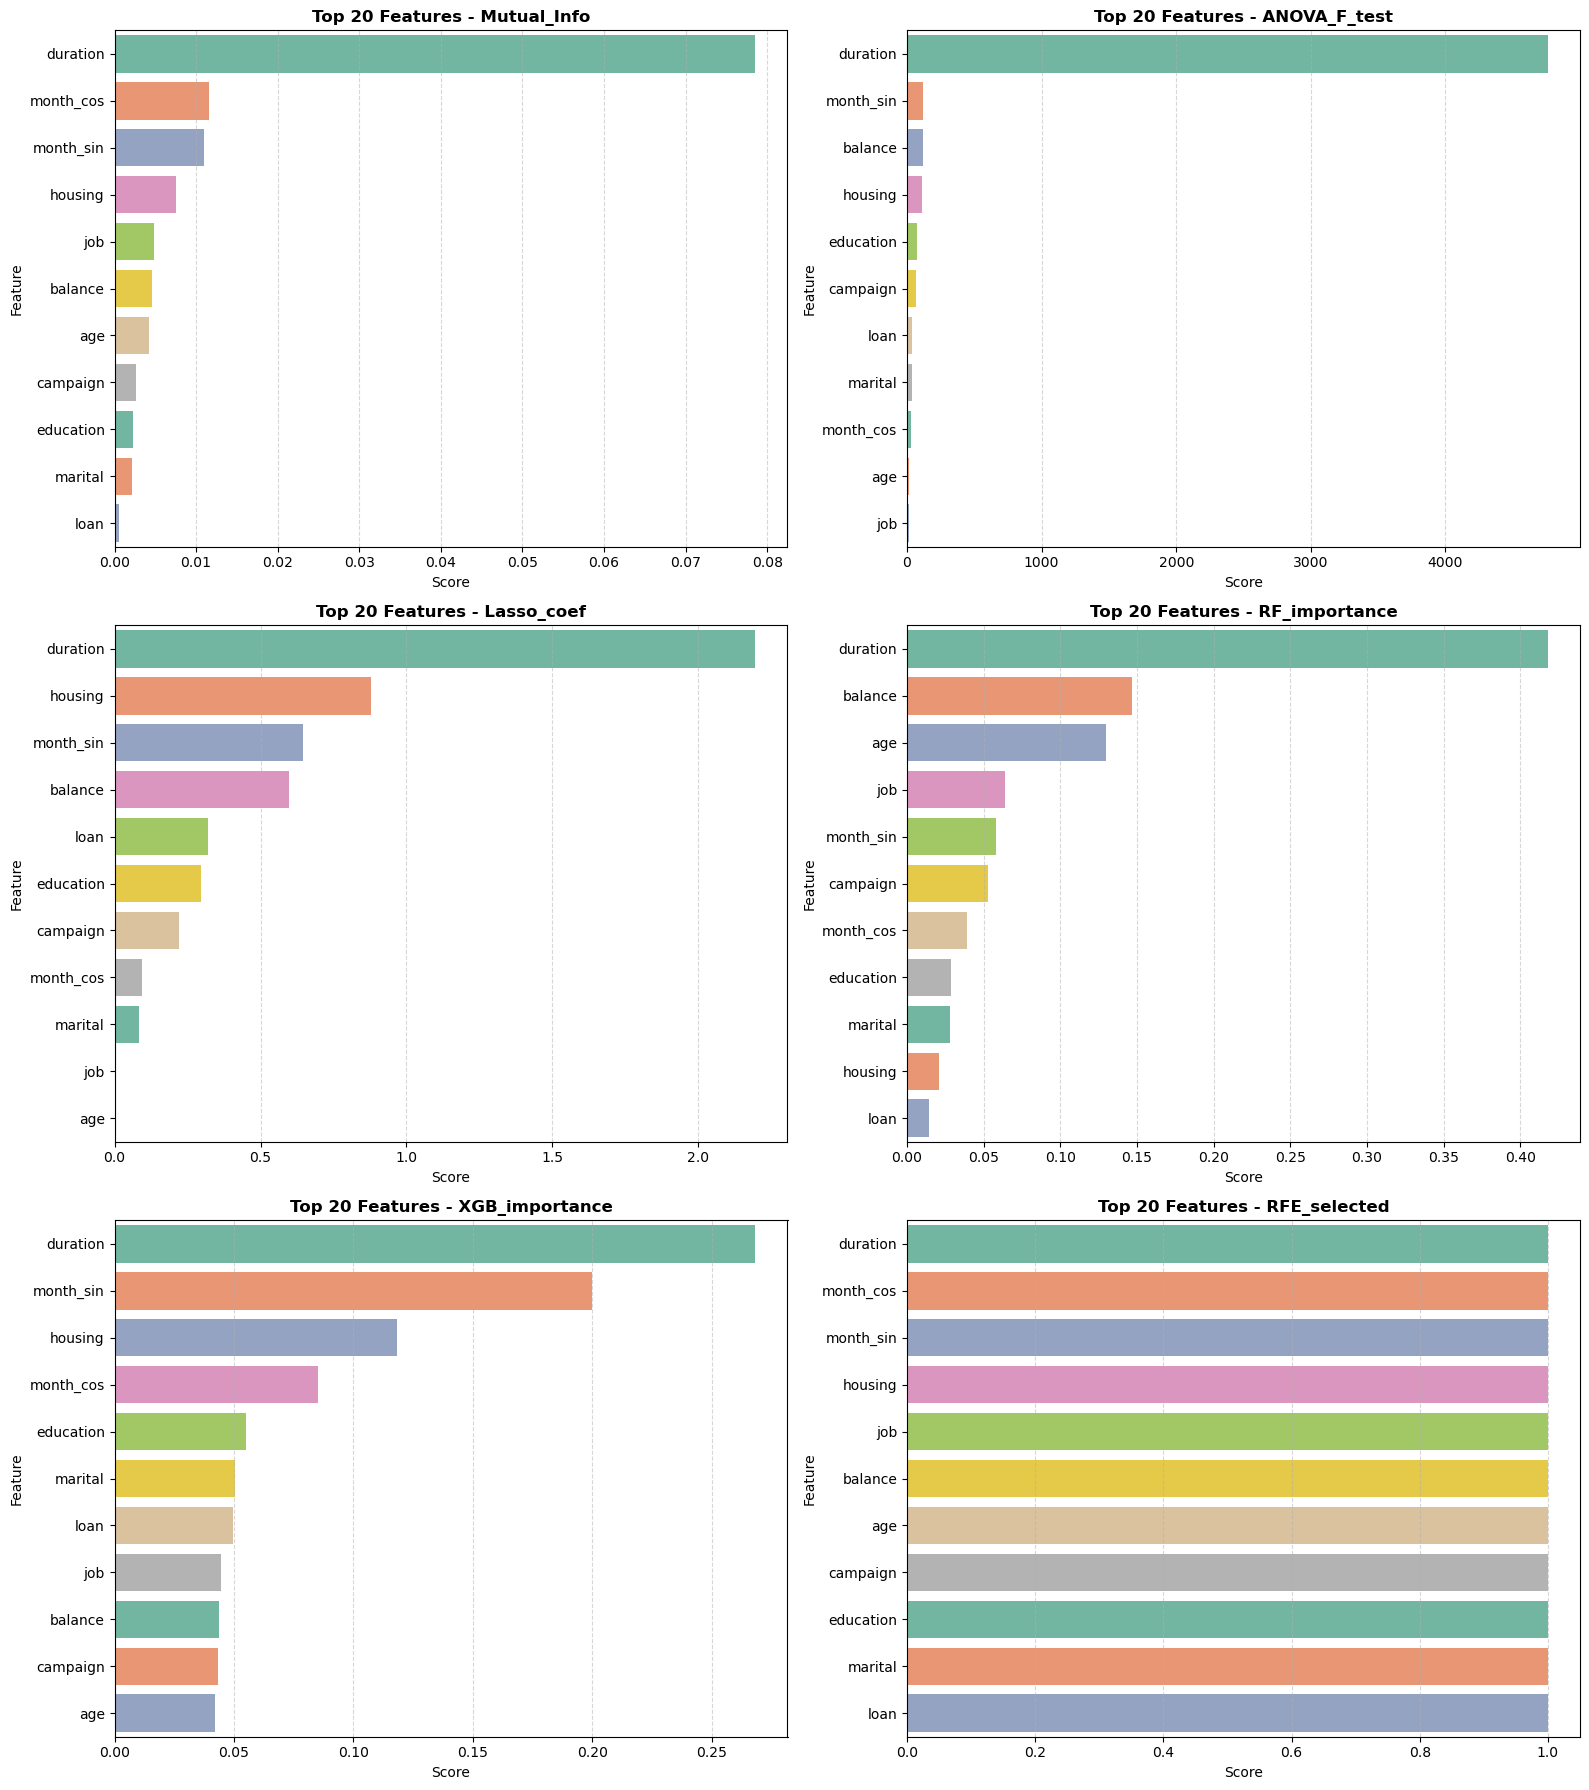

In [91]:
def plot_top_features(results, top_k=20):
    """Plot top_k features from each selection method."""
    importance_cols = ['Mutual_Info', 'ANOVA_F_test', 'Lasso_coef', 'RF_importance', 'XGB_importance', 'RFE_selected']
    melted = results[importance_cols].reset_index().melt(id_vars='index', var_name='Method', value_name='Score')
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
    axs = axs.flatten()

    for i, method in enumerate(importance_cols):
        subset = melted[melted['Method'] == method].nlargest(top_k, 'Score')
        sns.barplot(data=subset, y='index', x='Score', ax=axs[i], hue='index', palette='Set2', legend=False)
        axs[i].set_title(f"Top {top_k} Features - {method}", fontsize=12, fontweight='bold')
        axs[i].set_xlabel("Score")
        axs[i].set_ylabel("Feature")
        axs[i].grid(axis='x', linestyle='--', alpha=0.5)

    # Hide unused subplot if any
    if len(importance_cols) < len(axs):
        for j in range(len(importance_cols), len(axs)):
            fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

plot_top_features(feature_selection_results, top_k=20)

In [44]:
y_train.value_counts()

y
0    28436
1     2234
Name: count, dtype: int64

In [66]:
y_train.value_counts()

y
0    28436
1     2234
Name: count, dtype: int64

In [86]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from imblearn.under_sampling import TomekLinks
import pandas as pd


def resample_training_data(X_train, y_train, random_state=42):
    """
    Applies SMOTE to generate one balanced dataset and RandomUnderSampler to generate another.

    Original class distribution:
    - Class 0: 29683 (92.8%)
    - Class 1: 2317 (7.2%)

    Strategy:
    - SMOTE upsampling to increase minority class to 8000 (~27% of majority class)
    - Undersampling to reduce majority class to 2x the original minority class (4634)

    Parameters:
    - X_train (pd.DataFrame): Training features after feature selection.
    - y_train (pd.Series): Training labels.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - X_resampled_smote (pd.DataFrame): SMOTE-resampled training features.
    - y_resampled_smote (pd.Series): SMOTE-resampled training labels.
    - X_resampled_under (pd.DataFrame): Undersampled training features.
    - y_resampled_under (pd.Series): Undersampled training labels.
    """
    # SMOTE resampling
    smote = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=random_state)
    #smote = SMOTE(sampling_strategy=0.7, k_neighbors=3, random_state=random_state)
    X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

    # Undersampling
    #undersample = TomekLinks(sampling_strategy='auto')
    #X_resampled_under, y_resampled_under = undersample.fit_resample(X_train, y_train)

    # Random undersampling
    undersample = RandomUnderSampler(sampling_strategy=0.3,random_state=random_state)  # reduce majority to ~4634
    X_resampled_under, y_resampled_under = undersample.fit_resample(X_train, y_train)


    return X_resampled_smote, y_resampled_smote, X_resampled_under, y_resampled_under

smote_X,smote_Y, under_X, under_Y = resample_training_data(X_train, y_train)

In [96]:
smote_X,smote_Y, under_X, under_Y = resample_training_data(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    smote_X, smote_Y, test_size=0.20, stratify=smote_Y, random_state=42
)

In [ ]:
from sklearn.model_selection import train_test_split

X = term_deposit_changed_v3.drop(columns='y')
y = term_deposit_changed_v3['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

In [97]:
import warnings
import logging
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("lightgbm").setLevel(logging.ERROR)


def cross_validated_model_scores(X_train, y_train, X_test, y_test):
    random_seed = 42
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    cv_results = []

    # Define models and whether they need scaling
    models = {
        'Logistic Regression': (LogisticRegression(random_state=random_seed, max_iter=1000), True),
        'Random Forest': (RandomForestClassifier(random_state=random_seed), False),
        'XGBoost': (XGBClassifier(eval_metric='logloss', use_label_encoder=False, verbosity=0, random_state=random_seed), False),
        'LightGBM': (LGBMClassifier(verbosity=-1, random_state=random_seed), False),
        #'SVM': (SVC(probability=True, random_state=random_seed), True),
        #'Naive Bayes': (GaussianNB(), True),
        #'KNN': (KNeighborsClassifier(), True),
    }

    for name, (model, needs_scaling) in models.items():
        # Pipeline for scaling if needed
        steps = [('scaler', StandardScaler()), ('classifier', model)] if needs_scaling else [('classifier', model)]
        pipeline = Pipeline(steps)

        # Cross-validated predictions
        y_cv_pred = cross_val_predict(pipeline, X_train, y_train, cv=cv, method='predict')
        y_cv_proba = cross_val_predict(pipeline, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

        # Train on full training set
        pipeline.fit(X_train, y_train)
        y_test_pred = pipeline.predict(X_test)
        y_test_proba = pipeline.predict_proba(X_test)[:, 1]

        # Reports
        report_cv = classification_report(y_train, y_cv_pred, output_dict=True)
        report_test = classification_report(y_test, y_test_pred, output_dict=True)
        auc_cv = roc_auc_score(y_train, y_cv_proba)
        auc_test = roc_auc_score(y_test, y_test_proba)

        cv_results.append({
            'Model': name,
            'CV F1 (1)': report_cv['1']['f1-score'],
            'CV Precision (1)': report_cv['1']['precision'],
            'CV Recall (1)': report_cv['1']['recall'],
            'CV AUC': auc_cv,
            'Test F1 (1)': report_test['1']['f1-score'],
            'Test Precision (1)': report_test['1']['precision'],
            'Test Recall (1)': report_test['1']['recall'],
            'Test AUC': auc_test
        })

    results_df = pd.DataFrame(cv_results).sort_values(by='CV F1 (1)', ascending=False)
    print("Cross-Validated and Test Set Model Performance")
    display(results_df)
    return results_df


# Example run:
cv_results = cross_validated_model_scores(smote_X, smote_Y, X_test, y_test)

#cv_models = cross_validated_model_scores(smote_X, smote_Y)


Cross-Validated and Test Set Model Performance


,Model,CV F1 (1),CV Precision (1),CV Recall (1),CV AUC,Test F1 (1),Test Precision (1),Test Recall (1),Test AUC
1,Random Forest,0.956487,0.943974,0.969336,0.993336,1.000000,1.000000,1.000000,1.000000
2,XGBoost,0.948660,0.942717,0.954678,0.990520,0.963720,0.959688,0.967787,0.995603
3,LightGBM,0.945224,0.937147,0.953441,0.989432,0.948586,0.939683,0.957659,0.991254
0,Logistic Regression,0.854831,0.834132,0.876582,0.917409,0.853705,0.830430,0.878323,0.918331


In [87]:
cv_models = cross_validated_model_scores(under_X, under_Y, X_test, y_test)

Cross-Validated and Test Set Model Performance


,Model,CV F1 (1),CV Precision (1),CV Recall (1),CV AUC,Test F1 (1),Test Precision (1),Test Recall (1),Test AUC
3,LightGBM,0.734328,0.743202,0.725664,0.929540,0.534483,0.418354,0.739857,0.928095
1,Random Forest,0.733447,0.743612,0.723557,0.924737,0.518909,0.410864,0.704057,0.924604
2,XGBoost,0.716399,0.729058,0.704172,0.922958,0.509028,0.397849,0.706444,0.916612
0,Logistic Regression,0.641826,0.717335,0.580700,0.895115,0.482283,0.410385,0.584726,0.895450


In [47]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier

def xgb_objective(trial, X, y, cv_folds=5, scoring='f1'):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 400, 800]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 5, 10]),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'objective': 'binary:logistic'
    }

    model = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return scores.mean()

def xgb_optuna_study(X_train, y_train, X_test, y_test, n_trials=50, cv_folds=5, scoring='f1'):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: xgb_objective(trial, X_train, y_train, cv_folds, scoring), n_trials=n_trials)

    print("\nBest trial:")
    print(study.best_trial)

    best_params = study.best_trial.params
    best_params['use_label_encoder'] = False
    best_params['eval_metric'] = 'logloss'
    best_params['objective'] = 'binary:logistic'

    best_model = XGBClassifier(**best_params)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    print("\nTest Set Classification Report:")
    print(classification_report(y_test, y_pred))

    return best_model, study


best_model = xgb_optuna_study(under_X, under_Y, X_test, y_test)

[I 2025-05-26 18:44:27,593] A new study created in memory with name: no-name-4414124d-88cd-4d3c-a386-6e3e9c9a7aae
[I 2025-05-26 18:44:34,476] Trial 0 finished with value: 0.8639695698171082 and parameters: {'n_estimators': 100, 'learning_rate': 0.21579200667044754, 'max_depth': 3, 'gamma': 0.9307463936731044, 'subsample': 0.9758700736081098, 'colsample_bytree': 0.7840104019674649, 'scale_pos_weight': 1, 'reg_alpha': 0.46727294941217257, 'reg_lambda': 3.2921115287586504}. Best is trial 0 with value: 0.8639695698171082.
[I 2025-05-26 18:44:36,189] Trial 1 finished with value: 0.857461322375374 and parameters: {'n_estimators': 400, 'learning_rate': 0.010504233383288734, 'max_depth': 5, 'gamma': 0.4045460767123813, 'subsample': 0.6789937277697142, 'colsample_bytree': 0.7437098979650612, 'scale_pos_weight': 5, 'reg_alpha': 0.005276155385470882, 'reg_lambda': 3.2933224971709123}. Best is trial 0 with value: 0.8639695698171082.
[I 2025-05-26 18:44:37,644] Trial 2 finished with value: 0.865055


Best trial:
FrozenTrial(number=37, state=1, values=[0.8830182960354218], datetime_start=datetime.datetime(2025, 5, 26, 18, 44, 59, 651275), datetime_complete=datetime.datetime(2025, 5, 26, 18, 45, 0, 858203), params={'n_estimators': 800, 'learning_rate': 0.0103674692884994, 'max_depth': 8, 'gamma': 0.24577260960189412, 'subsample': 0.9150814624316147, 'colsample_bytree': 0.703208047741279, 'scale_pos_weight': 5, 'reg_alpha': 0.13914991847082048, 'reg_lambda': 2.992207799321976}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': CategoricalDistribution(choices=(100, 200, 400, 800)), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'gamma': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'scale_po

### Optuna, Hyperparameter tuning and threshold tuning:
Chosen to use Optuna for hyperparameter tuning for XGBoost as the final model and to evaluate their performance using 5-fold cross-validation on a SMOTE-balanced dataset. Goals is to maximize the F1-score which balances precision and recall, criticla in imbalanced classificatin tasks like term deposit prediction.


In [ ]:
# Import libraries for modeling, evaluation, optimization, and saving artifacts
import optuna
import joblib
import os
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import pandas as pd
import numpy as np

# Define 5-fold stratified cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



# Function to train and tune XGBoost using Optuna

def train_xgboost_with_optuna(X_train, y_train):
    # Subset training data to selected features
    #X_train = X_train[xgb_features]

    # Initialize XGBoost model with fixed evaluation metric
    model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
    print("Tuning XGBoost with Optuna...")

    # Define the objective function Optuna will optimize
    def objective(trial):
        # Suggest hyperparameters to tune from specified ranges
        model.set_params(
            n_estimators=trial.suggest_int('n_estimators', 100, 300),
            max_depth=trial.suggest_int('max_depth', 3, 7),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
            subsample=trial.suggest_float('subsample', 0.8, 1.0),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.8, 1.0),
            scale_pos_weight=trial.suggest_float('scale_pos_weight', 1.0, 20.0)
        )

        scores = []
        # Perform 5-fold CV and collect F1 scores for each fold
        for train_idx, val_idx in cv_strategy.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            model.fit(X_tr, y_tr)
            probas = model.predict_proba(X_val)[:, 1]
            preds = (probas >= 0.5).astype(int)  # fixed threshold during tuning
            scores.append(f1_score(y_val, preds))
        return np.mean(scores)  # return mean F1 across folds

    # Start Optuna study to maximize F1-score
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30, show_progress_bar=False)

    # Retrieve best parameters and train final model on full training set
    best_params = study.best_params
    model.set_params(**best_params)
    model.fit(X_train, y_train)

    # Save the trained model to disk
    os.makedirs("../models", exist_ok=True)
    joblib.dump(model, "../models/xgboost_model.pkl")

    # Print best F1 score from tuning and hyperparameters
    print("\nBest F1-Score from CV:", study.best_value)
    print("Best Hyperparameters:", best_params)

    return model, best_params

# Function to tune threshold and evaluate model on test set

def evaluate_xgboost_with_threshold(model, X_train, y_train, X_test, y_test):
    # Subset both train and test to selected features
    #X_train = X_train[xgb_features]
    #X_test = X_test[xgb_features]

    thresholds = np.arange(0.1, 0.9, 0.01)  # candidate thresholds
    best_thresh, best_f1 = 0.5, 0

    # Tune threshold based on F1 score via cross-validation
    for thresh in thresholds:
        fold_scores = []
        for train_idx, val_idx in cv_strategy.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            model.fit(X_tr, y_tr)
            probas = model.predict_proba(X_val)[:, 1]
            preds = (probas >= thresh).astype(int)
            fold_scores.append(f1_score(y_val, preds))
        avg_f1 = np.mean(fold_scores)
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_thresh = thresh

    # Save the best threshold to disk
    joblib.dump(best_thresh, "../models/xgboost_threshold.pkl")

    # Final test set evaluation using best threshold
    test_proba = model.predict_proba(X_test)[:, 1]
    final_preds = (test_proba >= best_thresh).astype(int)

    test_results = {
        'Model': 'XGBoost',
        'Best Threshold': round(best_thresh, 2),
        'Test Accuracy': accuracy_score(y_test, final_preds),
        'Test Precision': precision_score(y_test, final_preds),
        'Test Recall': recall_score(y_test, final_preds),
        'Test F1-Score': f1_score(y_test, final_preds),
        'Test AUC': roc_auc_score(y_test, test_proba)
    }

    results_df = pd.DataFrame([test_results])
    print("\nFinal Model Evaluation with Threshold Tuning")
    display(results_df)
    return results_df

# Example usage:
final_model, params = train_xgboost_with_optuna(under_X, under_Y)
final_results = evaluate_xgboost_with_threshold(final_model, under_X, under_Y, X_test, y_test)
#final_model, params = train_xgboost_with_optuna(smote_X, smote_Y)
#final_results = evaluate_xgboost_with_threshold(final_model, smote_X, smote_Y, X_test, y_test)


[I 2025-05-26 16:26:47,940] A new study created in memory with name: no-name-e0bcbc7f-f527-49a4-90e0-e0a136f78dce


Tuning XGBoost with Optuna...


[I 2025-05-26 16:26:48,315] Trial 0 finished with value: 0.7919427005769915 and parameters: {'n_estimators': 132, 'max_depth': 4, 'learning_rate': 0.24274844067796822, 'subsample': 0.8502873655583936, 'colsample_bytree': 0.8751714395783502, 'scale_pos_weight': 19.637792121210715}. Best is trial 0 with value: 0.7919427005769915.
[I 2025-05-26 16:26:48,921] Trial 1 finished with value: 0.8126739203250771 and parameters: {'n_estimators': 235, 'max_depth': 4, 'learning_rate': 0.23670459951114192, 'subsample': 0.9900999796856345, 'colsample_bytree': 0.9867318992643739, 'scale_pos_weight': 8.594796429890568}. Best is trial 1 with value: 0.8126739203250771.
[I 2025-05-26 16:26:49,541] Trial 2 finished with value: 0.8199296521576567 and parameters: {'n_estimators': 146, 'max_depth': 7, 'learning_rate': 0.22285315408129208, 'subsample': 0.8533466765924678, 'colsample_bytree': 0.952542943226809, 'scale_pos_weight': 15.175026551120295}. Best is trial 2 with value: 0.8199296521576567.
[I 2025-05-2


Best F1-Score from CV: 0.8357627409087538
Best Hyperparameters: {'n_estimators': 210, 'max_depth': 5, 'learning_rate': 0.11903465220667683, 'subsample': 0.9520352428658949, 'colsample_bytree': 0.8791626094365693, 'scale_pos_weight': 2.448449237462321}

Final Model Evaluation with Threshold Tuning


,Model,Best Threshold,Test Accuracy,Test Precision,Test Recall,Test F1-Score,Test AUC
0,XGBoost,0.52,0.868371,0.343808,0.887828,0.49567,0.936734


In [31]:
from sklearn.metrics import classification_report

def evaluate_model_default_threshold(model, X_test, y_test):
    """
    Evaluates a trained model on the test dataset using default threshold (0.5).

    Parameters:
        model: Trained classification model with predict_proba method
        X_test: Test set features
        y_test: Test set labels

    Returns:
        DataFrame with performance metrics using default threshold
    """
    # Predict probabilities
    probas = model.predict_proba(X_test)[:, 1]
    # Apply default threshold
    preds = (probas >= 0.5).astype(int)

    # Compute metrics
    results = {
        'Model': 'XGBoost',
        'Threshold': 0.5,
        'Test Accuracy': accuracy_score(y_test, preds),
        'Test Precision': precision_score(y_test, preds),
        'Test Recall': recall_score(y_test, preds),
        'Test F1-Score': f1_score(y_test, preds),
        'Test AUC': roc_auc_score(y_test, probas)
    }

    print("\nEvaluation Using Default Threshold (0.5)")
    print(classification_report(y_test, preds, zero_division=0))
    return pd.DataFrame([results])

default_eval_df = evaluate_model_default_threshold(final_model, X_test, y_test)
display(default_eval_df)


Evaluation Using Default Threshold (0.5)
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      5332
           1       0.34      0.90      0.49       419

    accuracy                           0.87      5751
   macro avg       0.67      0.88      0.71      5751
weighted avg       0.94      0.87      0.89      5751



,Model,Threshold,Test Accuracy,Test Precision,Test Recall,Test F1-Score,Test AUC
0,XGBoost,0.5,0.865589,0.339964,0.897375,0.493115,0.936734


In [9]:
import optuna
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def tune_xgboost_with_optuna(X_train, y_train):
    cv_results = []
    model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
    name = 'XGBoost'
    print(f"Tuning with Optuna: {name}")

    def objective(trial):
        model.set_params(
            n_estimators=trial.suggest_int('n_estimators', 100, 300),
            max_depth=trial.suggest_int('max_depth', 3, 7),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
            subsample=trial.suggest_float('subsample', 0.8, 1.0),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.8, 1.0),
            scale_pos_weight=trial.suggest_float('scale_pos_weight', 1.0, 20.0)
        )

        scores = []
        for train_idx, val_idx in cv_strategy.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model.fit(X_tr, y_tr)
            probas = model.predict_proba(X_val)[:, 1]
            preds = (probas >= 0.5).astype(int)
            scores.append(f1_score(y_val, preds))
        return np.mean(scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30, show_progress_bar=False)

    best_params = study.best_params
    model.set_params(**best_params)

    scores = []
    for train_idx, val_idx in cv_strategy.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        scores.append(f1_score(y_val, preds))

    cv_results.append({
        'Model': name,
        'Best Params': best_params,
        'CV F1-Score': np.mean(scores)
    })

    results_df = pd.DataFrame(cv_results).sort_values(by='CV F1-Score', ascending=False)
    print("\nCross-Validated Performance (Optuna Only)")
    display(results_df)
    return results_df

# usage:
tuned_xgboost_results = tune_xgboost_with_optuna(smote_X, smote_Y)


[I 2025-05-25 20:12:40,017] A new study created in memory with name: no-name-d4366746-c563-4eb9-adef-34a3523e2eda


Tuning with Optuna: XGBoost


[I 2025-05-25 20:12:41,018] Trial 0 finished with value: 0.9207411729706461 and parameters: {'n_estimators': 160, 'max_depth': 4, 'learning_rate': 0.18595910289155032, 'subsample': 0.898286330557868, 'colsample_bytree': 0.8502353671389308, 'scale_pos_weight': 11.614686643260987}. Best is trial 0 with value: 0.9207411729706461.
[I 2025-05-25 20:12:42,273] Trial 1 finished with value: 0.9400364195987088 and parameters: {'n_estimators': 135, 'max_depth': 6, 'learning_rate': 0.2204139972561775, 'subsample': 0.8471480571213691, 'colsample_bytree': 0.9503220626933847, 'scale_pos_weight': 14.986980210082407}. Best is trial 1 with value: 0.9400364195987088.
[I 2025-05-25 20:12:43,899] Trial 2 finished with value: 0.9409284180728663 and parameters: {'n_estimators': 297, 'max_depth': 4, 'learning_rate': 0.23349303894108506, 'subsample': 0.90692095276403, 'colsample_bytree': 0.8541457537636613, 'scale_pos_weight': 8.980137709941905}. Best is trial 2 with value: 0.9409284180728663.
[I 2025-05-25 2


Cross-Validated Performance (Optuna Only)


,Model,Best Params,CV F1-Score
0,XGBoost,"{'n_estimators': 264, 'max_depth': 4, 'learnin...",0.95751


Here's a detailed explanation of the **XGBoost parameters** being tuned in your `objective()` function using Optuna:

---

## XGBoost Hyperparameters Tuned

### 1. `n_estimators`

```python
n_estimators = trial.suggest_int('n_estimators', 100, 300)
```

* **What it does**: Number of boosting rounds (trees in the ensemble).
* **Why it's important**: More trees → potentially better learning, but too many can cause overfitting and longer training.
* **Range rationale**: 100–300 is a practical range to balance accuracy and efficiency.

---

### 2. `max_depth`

```python
max_depth = trial.suggest_int('max_depth', 3, 7)
```

* **What it does**: Maximum depth of a tree.
* **Why it's important**: Controls the complexity of each individual tree. Higher values allow learning more interactions, but increase risk of overfitting.
* **Range rationale**:

  * 3 → shallow, faster, regularized.
  * 7 → more expressive model.
  * Good for tabular datasets.

---

### 3. `learning_rate`

```python
learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
```

* **What it does**: Shrinks the contribution of each tree (step size in gradient descent).
* **Why it's important**: Smaller values improve generalization but need more trees. Large values converge faster but may overshoot minima.
* **Range rationale**: 0.01 (slow but stable) to 0.3 (aggressive learning).

---

### 4. `subsample`

```python
subsample = trial.suggest_float('subsample', 0.8, 1.0)
```

* **What it does**: Fraction of the training data used to grow each tree.
* **Why it's important**: Introduces randomness, helps avoid overfitting.
* **Range rationale**:

  * 1.0 = use full data.
  * <1.0 = introduces stochasticity (bagging-like effect).
  * 0.8 is a common best practice lower bound.

---

### 5. `colsample_bytree`

```python
colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
```

* **What it does**: Fraction of features to use when building each tree.
* **Why it's important**: Reduces correlation between trees, helps regularize.
* **Range rationale**: Like `subsample`, encourages diversity. 0.8 is typical for structured data.

---

## Summary: Why These Parameters

| Parameter          | Purpose                               | Helps With               |
| ------------------ | ------------------------------------- | ------------------------ |
| `n_estimators`     | Controls number of trees              | Underfitting/overfitting |
| `max_depth`        | Controls tree complexity              | Model expressiveness     |
| `learning_rate`    | Balances learning speed and precision | Generalization           |
| `subsample`        | Adds randomness, reduces overfit      | Regularization           |
| `colsample_bytree` | Randomizes feature usage per tree     | Feature decorrelation    |

Together, these **cover tree size, learning dynamics, and regularization** — the core levers for optimizing XGBoost performance.

---

Let me know if you want to:

* Add other XGBoost parameters (e.g., `gamma`, `min_child_weight`)
* Visualize the Optuna tuning history or best hyperparameter values
* Apply different parameter grids for LightGBM or RF based on dataset characteristics


### Threshold tuning